# Natural language processing on Financial Statements

## Amazon vs McDonalds

To investigate whether in recent years, online shopping giants like Amazon has overall positive sentiments in the public compared to McDonald's; expecially in the wake of COVID-19 where there are several restrictions and lockdown in place in many countries.

### Load Packages

In [1]:
import nltk
import numpy as np
import pandas as pd
import pickle
import pprint
import project_helper
import project_tests

from tqdm import tqdm

### Download NLP Corpora
You'll need two corpora to run this project: the stopwords corpus for removing stopwords and wordnet for lemmatizing.

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pruthvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pruthvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Get 10ks
We'll be running NLP analysis on 10-k documents. To do that, we first need to download the documents. For this project, we'll download 10-ks for a few companies. To lookup documents for these companies, we'll use their CIK. If you would like to run this against other stocks, we've provided the dict `additional_cik` for more stocks. However, the more stocks you try, the long it will take to run.

In [3]:
# UBSLON BRANCH CIK#: 0001168525 (see all company filings)
# UBSNY BRANCH CIK#: 0001070765 (see all company filings)

In [4]:
cik_lookup = {
    'AMZN': '0001018724',
    'BMY': '0000014272',   
    'CNP': '0001130310',
    'FRT': '0000034903',
    'HON': '0000773840',
    'IBM': '0000051143',
    'MCD': '0000063908'}

additional_cik = {
    'CVX': '0000093410',
    'FL': '0000850209',
    'AEP': '0000004904',
    'AXP': '0000004962',
    'BA': '0000012927', 
    'BK': '0001390777',
    'CAT': '0000018230',
    'DE': '0000315189',
    'DIS': '0001001039',
    'DTE': '0000936340',
    'ED': '0001047862',
    'EMR': '0000032604',
    'ETN': '0001551182',
    'GE': '0000040545',
    'IBM': '0000051143',
    'IP': '0000051434',
    'JNJ': '0000200406',
    'KO': '0000021344',
    'LLY': '0000059478',
    'MCD': '0000063908',
    'MO': '0000764180',
    'MRK': '0000310158',
    'MRO': '0000101778',
    'PCG': '0001004980',
    'PEP': '0000077476',
    'PFE': '0000078003',
    'PG': '0000080424',
    'PNR': '0000077360',
    'SYY': '0000096021',
    'TXN': '0000097476',
    'UTX': '0000101829',
    'WFC': '0000072971',
    'WMT': '0000104169',
    'WY': '0000106535',
    'XOM': '0000034088'}

### Get list of 10-ks
The SEC has a limit on the number of calls you can make to the website per second. In order to avoid hiding that limit, we've created the `SecAPI` class. This will cache data from the SEC and prevent you from going over the limit.

In [5]:
sec_api = project_helper.SecAPI()

With the class constructed, let's pull a list of filled 10-ks from the SEC for each company.

In [6]:
from bs4 import BeautifulSoup

def get_sec_data(cik, doc_type, start=0, count=60):
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)]

    return entries

Let's pull the list using the `get_sec_data` function, then display some of the results. For displaying some of the data, we'll use MCDONALDS CORP as an example. 

In [7]:
example_ticker = 'MCD'
sec_data = {}

for ticker, cik in cik_lookup.items():
    sec_data[ticker] = get_sec_data(cik, '10-K')

pprint.pprint(sec_data[example_ticker][:5])

[('https://www.sec.gov/Archives/edgar/data/63908/000006390820000022/0000063908-20-000022-index.htm',
  '10-K',
  '2020-02-26'),
 ('https://www.sec.gov/Archives/edgar/data/63908/000006390819000010/0000063908-19-000010-index.htm',
  '10-K',
  '2019-02-22'),
 ('https://www.sec.gov/Archives/edgar/data/63908/000006390818000010/0000063908-18-000010-index.htm',
  '10-K',
  '2018-02-23'),
 ('https://www.sec.gov/Archives/edgar/data/63908/000006390817000017/0000063908-17-000017-index.htm',
  '10-K',
  '2017-03-01'),
 ('https://www.sec.gov/Archives/edgar/data/63908/000006390816000103/0000063908-16-000103-index.htm',
  '10-K',
  '2016-02-25')]


### Download 10-ks
As you see, this is a list of urls. These urls point to a file that contains metadata related to each filling. Since we don't care about the metadata, we'll pull the filling by replacing the url with the filling url.

In [8]:
raw_fillings_by_ticker = {}

for ticker, data in sec_data.items():
    raw_fillings_by_ticker[ticker] = {}
    for index_url, file_type, file_date in tqdm(data, desc='Downloading {} Fillings'.format(ticker), unit='filling'):
        if (file_type == '10-K'):
            file_url = index_url.replace('-index.htm', '.txt').replace('.txtl', '.txt')            
            
            raw_fillings_by_ticker[ticker][file_date] = sec_api.get(file_url)


print('Example Document:\n\n{}...'.format(next(iter(raw_fillings_by_ticker[example_ticker].values()))[:1000]))

Example Document:

<SEC-DOCUMENT>0000063908-20-000022.txt : 20200226
<SEC-HEADER>0000063908-20-000022.hdr.sgml : 20200226
<ACCEPTANCE-DATETIME>20200226115802
ACCESSION NUMBER:		0000063908-20-000022
CONFORMED SUBMISSION TYPE:	10-K
PUBLIC DOCUMENT COUNT:		102
CONFORMED PERIOD OF REPORT:	20191231
FILED AS OF DATE:		20200226
DATE AS OF CHANGE:		20200226

FILER:

	COMPANY DATA:	
		COMPANY CONFORMED NAME:			MCDONALDS CORP
		CENTRAL INDEX KEY:			0000063908
		STANDARD INDUSTRIAL CLASSIFICATION:	RETAIL-EATING PLACES [5812]
		IRS NUMBER:				362361282
		STATE OF INCORPORATION:			DE
		FISCAL YEAR END:			1231

	FILING VALUES:
		FORM TYPE:		10-K
		SEC ACT:		1934 Act
		SEC FILE NUMBER:	001-05231
		FILM NUMBER:		20654034

	BUSINESS ADDRESS:	
		STREET 1:		110 NORTH CARPENTER STREET
		CITY:			CHICAGO
		STATE:			IL
		ZIP:			60607
		BUSINESS PHONE:		630 623 3000

	MAIL ADDRESS:	
		STREET 1:		110 NORTH CARPENTER STREET
		CITY:			CHICAGO
		STATE:			IL
		ZIP:			60607
</SEC-HEADER>
<DOCUMENT>
<TYPE>10-K
<SEQU

### Get Documents
With theses fillings downloaded, we want to break them into their associated documents. These documents are sectioned off in the fillings with the tags `<DOCUMENT>` for the start of each document and `</DOCUMENT>` for the end of each document. There's no overlap with these documents, so each `</DOCUMENT>` tag should come after the `<DOCUMENT>` with no `<DOCUMENT>` tag in between.


In [9]:
import re


def get_documents(text):
    """
    Extract the documents from the text

    Parameters
    ----------
    text : str
        The text with the document strings inside

    Returns
    -------
    extracted_docs : list of str
        The document strings found in `text`
    """
    
    # TODO: Implement
    extracted_docs = []
    
    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')   
    
    doc_start_is = [x.end() for x in doc_start_pattern.finditer(text)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(text)]
    
    for doc_start_i, doc_end_i in zip(doc_start_is, doc_end_is):
            extracted_docs.append(text[doc_start_i:doc_end_i])
    
    return extracted_docs


project_tests.test_get_documents(get_documents)

Tests Passed


With the `get_documents` function implemented, let's extract all the documents.

In [10]:
filling_documents_by_ticker = {}

for ticker, raw_fillings in raw_fillings_by_ticker.items():
    filling_documents_by_ticker[ticker] = {}
    for file_date, filling in tqdm(raw_fillings.items(), desc='Getting Documents from {} Fillings'.format(ticker), unit='filling'):
        filling_documents_by_ticker[ticker][file_date] = get_documents(filling)


print('\n\n'.join([
    'Document {} Filed on {}:\n{}...'.format(doc_i, file_date, doc[:200])
    for file_date, docs in filling_documents_by_ticker[example_ticker].items()
    for doc_i, doc in enumerate(docs)][:3]))

Getting Documents from MCD Fillings: 100%|████████████████████████████████████████| 25/25 [00:00<00:00, 47.98filling/s]


Document 0 Filed on 2020-02-26:

<TYPE>10-K
<SEQUENCE>1
<FILENAME>mcd-12312019x10k.htm
<DESCRIPTION>FORM 10-K
<TEXT>
<XBRL>
<?xml version="1.0" encoding="UTF-8"?>
<!--XBRL Document Created with Wdesk from Workiva-->
<!--p:78f258e2a8...

Document 1 Filed on 2020-02-26:

<TYPE>EX-4.C
<SEQUENCE>2
<FILENAME>mcd-12312019xex4c10xk.htm
<DESCRIPTION>DESCRIPTION OF SECURITIES
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/l...

Document 2 Filed on 2020-02-26:

<TYPE>EX-12
<SEQUENCE>3
<FILENAME>mcd-12312019xex1210xk.htm
<DESCRIPTION>COMPUTATION OF RATIOS
<TEXT>
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose....


### Get Document Types
Now that we have all the documents, we want to find the 10-k form in this 10-k filing. Implement the `get_document_type` function to return the type of document given. The document type is located on a line with the `<TYPE>` tag. For example, a form of type "TEST" would have the line `<TYPE>TEST`. Make sure to return the type as lowercase, so this example would be returned as "test".

In [11]:
def get_document_type(doc):
    """
    Return the document type lowercased

    Parameters
    ----------
    doc : str
        The document string

    Returns
    -------
    doc_type : str
        The document type lowercased
    """
    
    # TODO: Implement
    type_pattern = re.compile(r'<TYPE>[^\n]+')
    
    doc_type = type_pattern.findall(doc)[0][len('<TYPE>'):] 
    
    return doc_type.lower()


project_tests.test_get_document_type(get_document_type)

Tests Passed


With the `get_document_type` function, we'll filter out all non 10-k documents.

In [12]:
ten_ks_by_ticker = {}

for ticker, filling_documents in filling_documents_by_ticker.items():
    ten_ks_by_ticker[ticker] = []
    for file_date, documents in filling_documents.items():
        for document in documents:
            if get_document_type(document) == '10-k':
                ten_ks_by_ticker[ticker].append({
                    'cik': cik_lookup[ticker],
                    'file': document,
                    'file_date': file_date})


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['cik', 'file', 'file_date'])

[
  {
    cik: '0000063908'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>mcd-12312019...
    file_date: '2020-02-26'},
  {
    cik: '0000063908'
    file: '\n<TYPE>10-K\n<SEQUENCE>16\n<FILENAME>mcd-1231201...
    file_date: '2020-02-26'},
  {
    cik: '0000063908'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>mcd-12312018...
    file_date: '2019-02-22'},
  {
    cik: '0000063908'
    file: '\n<TYPE>10-K\n<SEQUENCE>16\n<FILENAME>mcd-1231201...
    file_date: '2019-02-22'},
  {
    cik: '0000063908'
    file: '\n<TYPE>10-K\n<SEQUENCE>1\n<FILENAME>mcd-12312017...
    file_date: '2018-02-23'},
]


## Preprocess the Data
### Clean Up
As you can see, the text for the documents are very messy. To clean this up, we'll remove the html and lowercase all the text.

In [13]:
def remove_html_tags(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    return text


def clean_text(text):
    text = text.lower()
    text = remove_html_tags(text)
    
    return text

Using the `clean_text` function, we'll clean up all the documents.

In [14]:
for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Cleaning {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_clean'] = clean_text(ten_k['file'])


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_clean'])

Cleaning MCD 10-Ks: 100%|████████████████████████████████████████████████████████████| 41/41 [00:31<00:00,  1.3110-K/s]


[
  {
    file_clean: '\n10-k\n1\nmcd-12312019x10k.htm\nform 10-k\n\n\n\...},
  {
    file_clean: '\n10-k\n16\nmcd-1231201910k.pdf\npdf of entire fo...},
  {
    file_clean: '\n10-k\n1\nmcd-12312018x10k.htm\nform 10-k\n\n\n\...},
  {
    file_clean: '\n10-k\n16\nmcd-1231201810k.pdf\npdf of entire fo...},
  {
    file_clean: '\n10-k\n1\nmcd-12312017x10k.htm\nform 10-k\n\n\n\...},
]


### Lemmatize
With the text cleaned up, it's time to distill the verbs down. Implement the `lemmatize_words` function to lemmatize verbs in the list of words provided.

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet


def lemmatize_words(words):
    """
    Lemmatize words 

    Parameters
    ----------
    words : list of str
        List of words

    Returns
    -------
    lemmatized_words : list of str
        List of lemmatized words
    """
    
    # TODO: Implement
    lemmatized_words = [WordNetLemmatizer().lemmatize(word, 'v') for word in words]
    
    return lemmatized_words


project_tests.test_lemmatize_words(lemmatize_words)

Tests Passed


With the `lemmatize_words` function implemented, let's lemmatize all the data.

In [16]:
word_pattern = re.compile('\w+')

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Lemmatize {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = lemmatize_words(word_pattern.findall(ten_k['file_clean']))


project_helper.print_ten_k_data(ten_ks_by_ticker[example_ticker][:5], ['file_lemma'])

Lemmatize MCD 10-Ks: 100%|███████████████████████████████████████████████████████████| 41/41 [00:16<00:00,  2.4210-K/s]


[
  {
    file_lemma: '['10', 'k', '1', 'mcd', '12312019x10k', 'htm', 'f...},
  {
    file_lemma: '['10', 'k', '16', 'mcd', '1231201910k', 'pdf', 'p...},
  {
    file_lemma: '['10', 'k', '1', 'mcd', '12312018x10k', 'htm', 'f...},
  {
    file_lemma: '['10', 'k', '16', 'mcd', '1231201810k', 'pdf', 'p...},
  {
    file_lemma: '['10', 'k', '1', 'mcd', '12312017x10k', 'htm', 'f...},
]


### Remove Stopwords

In [17]:
from nltk.corpus import stopwords


lemma_english_stopwords = lemmatize_words(stopwords.words('english'))

for ticker, ten_ks in ten_ks_by_ticker.items():
    for ten_k in tqdm(ten_ks, desc='Remove Stop Words for {} 10-Ks'.format(ticker), unit='10-K'):
        ten_k['file_lemma'] = [word for word in ten_k['file_lemma'] if word not in lemma_english_stopwords]


print('Stop Words Removed')

Remove Stop Words for MCD 10-Ks: 100%|███████████████████████████████████████████████| 41/41 [00:10<00:00,  4.0610-K/s]


Stop Words Removed


## Analysis on 10ks
### Loughran McDonald Sentiment Word Lists
We'll be using the Loughran and McDonald sentiment word lists. These word lists cover the following sentiment:
- Negative 
- Positive
- Uncertainty
- Litigious
- Constraining
- Superfluous
- Modal

This will allow us to do the sentiment analysis on the 10-ks. Let's first load these word lists. We'll be looking into a few of these sentiments.

In [18]:
import os


sentiments = ['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting']

sentiment_df = pd.read_csv('LoughranMcDonald_MasterDictionary_2018.csv')
sentiment_df.columns = [column.lower() for column in sentiment_df.columns] # Lowercase the columns for ease of use

# Remove unused information
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]

# Apply the same preprocessing to these words as the 10-k words
sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
sentiment_df = sentiment_df.drop_duplicates('word')


sentiment_df.head()

,negative,positive,uncertainty,litigious,constraining,interesting,word
9,True,False,False,False,False,False,abandon
12,True,False,False,False,False,False,abandonment
13,True,False,False,False,False,False,abandonments
51,True,False,False,False,False,False,abdicate
54,True,False,False,False,False,False,abdication


### Bag of Words
using the sentiment word lists, let's generate sentiment bag of words from the 10-k documents. Implement `get_bag_of_words` to generate a bag of words that counts the number of sentiment words in each doc. You can ignore words that are not in `sentiment_words`.

In [19]:
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_bag_of_words(sentiment_words, docs):
    """
    Generate a bag of words from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = CountVectorizer(vocabulary=sentiment_words)
    vectors = vec.fit_transform(docs)
    words_list = vec.get_feature_names()
    bag_of_words = np.zeros([len(docs), len(words_list)])
    
    for i in range(len(docs)):
        bag_of_words[i] = vectors[i].toarray()[0]

    return bag_of_words.astype(int)


project_tests.test_get_bag_of_words(get_bag_of_words)

Tests Passed


Using the `get_bag_of_words` function, we'll generate a bag of words for all the documents.

In [20]:
sentiment_bow_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_bow_ten_ks[ticker] = {
        sentiment: get_bag_of_words(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}


project_helper.print_ten_k_data([sentiment_bow_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    positive: '[[6 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [7 0 0 ....
    uncertainty: '[[ 0  0  0 ...  1  1 10]\n [ 0  0  0 ...  0  0  0...
    litigious: '[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    constraining: '[[0 0 0 ... 0 0 1]\n [0 0 0 ... 0 0 0]\n [0 0 0 ....
    interesting: '[[2 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [2 1 0 ....},
]


### Jaccard Similarity
Now that we have the bag of words, we can convert it into a boolean array and calculate the jaccard similarity. The jaccard similarity is defined as the size of intersection divided by the size of union of two sets. For example, the jaccard similarity between two sentences is the number of common words between the two sentences divided by the total number of unique words in both sentences combined. The closer the jaccard similarity value is to 1, the more similar the sets are. To more easily understand our calculations, we plot the jaccard similarities.

In [21]:
from sklearn.metrics import jaccard_similarity_score


def get_jaccard_similarity(bag_of_words_matrix):
    """
    Get jaccard similarities for neighboring documents

    Parameters
    ----------
    bag_of_words : 2-d Numpy Ndarray of int
        Bag of words sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    jaccard_similarities : list of float
        Jaccard similarities for neighboring documents
    """
    
    # TODO: Implement
    jaccard_similarities = []
    bag_of_words_matrix = np.array(bag_of_words_matrix, dtype=bool)
    
    for i in range(len(bag_of_words_matrix)-1):
            u = bag_of_words_matrix[i]
            v = bag_of_words_matrix[i+1]
            jaccard_similarities.append(jaccard_similarity_score(u,v))    
    
    return jaccard_similarities


project_tests.test_get_jaccard_similarity(get_jaccard_similarity)

Tests Passed


Using the `get_jaccard_similarity` function, let's plot the similarities over time.

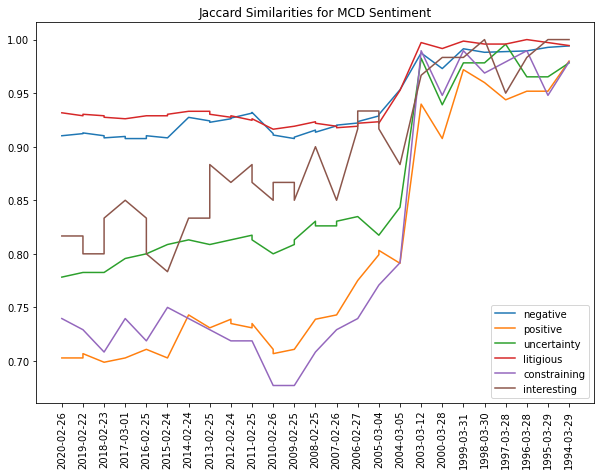

In [52]:
# Get dates for the universe
file_dates = {
    ticker: [ten_k['file_date'] for ten_k in ten_ks]
    for ticker, ten_ks in ten_ks_by_ticker.items()}  
# file_dates=np.transpose(file_dates)

jaccard_similarities = {
    ticker: {
        sentiment_name: get_jaccard_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_bow_ten_ks.items()}


### Amazon vs McDonalds -- due to COVID-19 
Let's see whether the current restrictions to go out has increased online shopping/ positive sentiments and decreased MCD positive sentiments  

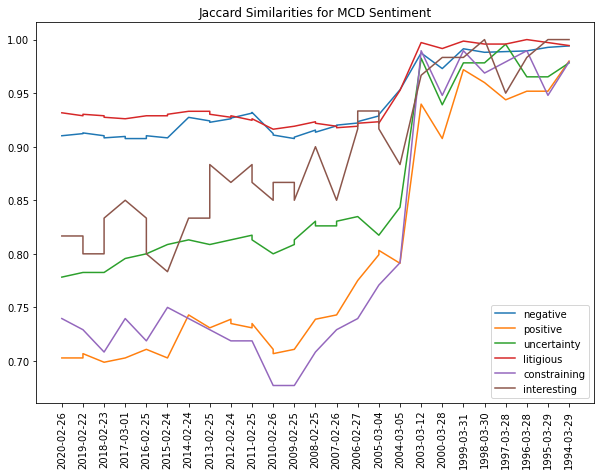

In [64]:
import project_helper

example_ticker='MCD'

project_helper.plot_similarities(
    [jaccard_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

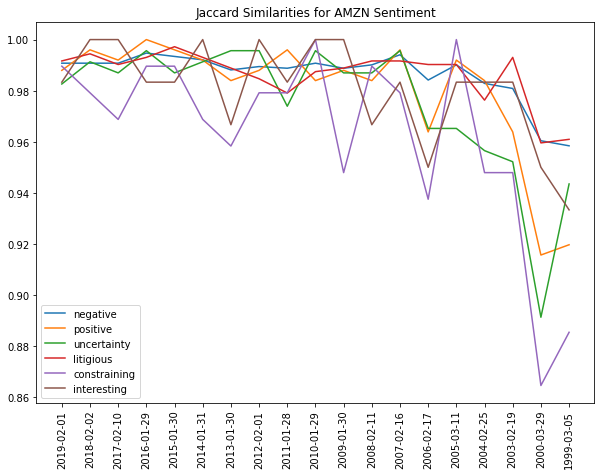

In [66]:
example_ticker1='AMZN'

project_helper.plot_similarities(
    [jaccard_similarities[example_ticker1][sentiment] for sentiment in sentiments],
    file_dates[example_ticker1][1:],
    'Jaccard Similarities for {} Sentiment'.format(example_ticker1),
    sentiments)

### TFIDF
From the sentiment word lists, let’s generate sentiment term frequency–inverse document frequency (TFIDF) from the 10-k documents. TFIDF is an information retrieval technique used to reveal how often a word/term appears in the chosen collection of text. Each term is assigned a term frequency (TF) and inverse document frequency (IDF) score. The product of these scores is referred to as the TFIDF weight of the term. Higher TFIDF weights indicate rarer terms and lower TFIDF scores indicate more common terms.


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_words, docs):
    """
    Generate TFIDF values from documents for a certain sentiment

    Parameters
    ----------
    sentiment_words: Pandas Series
        Words that signify a certain sentiment
    docs : list of str
        List of documents used to generate bag of words

    Returns
    -------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.
    """
    
    # TODO: Implement
    vec = TfidfVectorizer(vocabulary=sentiment_words)
    tfidf = vec.fit_transform(docs)
    
    return tfidf.toarray()


project_tests.test_get_tfidf(get_tfidf)

Tests Passed


Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [68]:
sentiment_tfidf_ten_ks = {}

for ticker, ten_ks in ten_ks_by_ticker.items():
    lemma_docs = [' '.join(ten_k['file_lemma']) for ten_k in ten_ks]
    
    sentiment_tfidf_ten_ks[ticker] = {
        sentiment: get_tfidf(sentiment_df[sentiment_df[sentiment]]['word'], lemma_docs)
        for sentiment in sentiments}

    
project_helper.print_ten_k_data([sentiment_tfidf_ten_ks[example_ticker]], sentiments)

[
  {
    negative: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    positive: '[[0.07908767 0.         0.         ... 0.        ...
    uncertainty: '[[0.         0.         0.         ... 0.0118765 ...
    litigious: '[[0. 0. 0. ... 0. 0. 0.]\n [0. 0. 0. ... 0. 0. 0....
    constraining: '[[0.         0.         0.         ... 0.        ...
    interesting: '[[0.01944892 0.         0.         ... 0.        ...},
]


### Cosine Similarity
From our TFIDF values, we can calculate the cosine similarity and plot it over time. Similar to jaccard similarity, cosine similarity is a metric used to determine how similar documents are. Cosine similarity calculates similarity irrespective of size by measuring the cosine of the angle between two vectors projected in a multi-dimensional space. For textual analysis, the two vectors used are usually arrays containing the word counts of two documents.


In [70]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    """
    Get cosine similarities for each neighboring TFIDF vector/document

    Parameters
    ----------
    tfidf : 2-d Numpy Ndarray of float
        TFIDF sentiment for each document
        The first dimension is the document.
        The second dimension is the word.

    Returns
    -------
    cosine_similarities : list of float
        Cosine similarities for neighboring documents
    """
    
    # TODO: Implement
    cosine_similarities = []    
    
    for i in range(len(tfidf_matrix)-1):
        cosine_similarities.append(cosine_similarity(tfidf_matrix[i].reshape(1, -1),tfidf_matrix[i+1].reshape(1, -1))[0,0])
    
    return cosine_similarities


project_tests.test_get_cosine_similarity(get_cosine_similarity)

Tests Passed


Let's plot the cosine similarities over time.

In [71]:
cosine_similarities = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_ten_ks.items()}

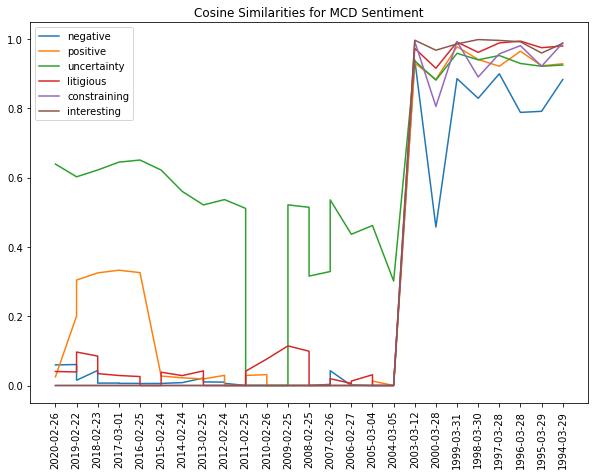

In [72]:

project_helper.plot_similarities(
    [cosine_similarities[example_ticker][sentiment] for sentiment in sentiments],
    file_dates[example_ticker][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker),
    sentiments)

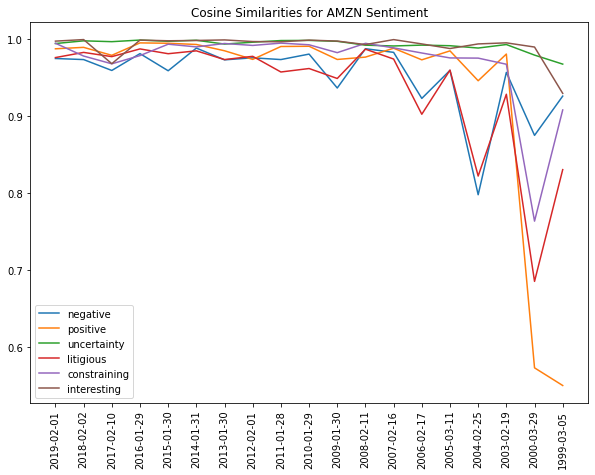

In [73]:

project_helper.plot_similarities(
    [cosine_similarities[example_ticker1][sentiment] for sentiment in sentiments],
    file_dates[example_ticker1][1:],
    'Cosine Similarities for {} Sentiment'.format(example_ticker1),
    sentiments)

As expected, we can see higher positive sentiments in recent years whereas for MCD, there is lot of negative sentiments. However these sentiments in general are not related to COVID-19! 

Next project would be to check whether these sentiments correlate with the prices of the stocks. This is however quite hard task as many complex factors influence the price of stocks in the real world.
